In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-ara-7-0/sample_submission.csv
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_262.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_086.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_097.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_108.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_157.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_240.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_324.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_034.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_087.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_271.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_122.jpg
/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images/test_100.jpg
/kaggle/input/data-science-ara-

# 1. Mengimpor Library dan Menyeting Style

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

In [22]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# 2. Memahami Masalah dan Overview

In [23]:
# Define paths
train_images_path = '/kaggle/input/data-science-ara-7-0/dataset/dataset/train/images'
train_mask_path = '/kaggle/input/data-science-ara-7-0/dataset/dataset/train/mask'
test_images_path = '/kaggle/input/data-science-ara-7-0/dataset/dataset/test/images'

In [24]:
# Count files
train_images = sorted([f for f in os.listdir(train_images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
train_masks = sorted([f for f in os.listdir(train_mask_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
test_images = sorted([f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("="*70)
print(" DATASET STRUCTURE ".center(70, "="))
print("="*70)
print(f"\n📁 Training Images:  {len(train_images):4d} files")
print(f"📁 Training Masks:   {len(train_masks):4d} files")
print(f"📁 Test Images:      {len(test_images):4d} files")

total = len(train_images) + len(test_images)
print(f"\n📊 Train-Test Split: {len(train_images)}/{len(test_images)} " +
      f"({len(train_images)/total*100:.1f}% / {len(test_images)/total*100:.1f}%)")

# Verify data integrity
train_image_names = {f.split('.')[0] for f in train_images}
train_mask_names = {f.split('.')[0] for f in train_masks}

missing_masks = train_image_names - train_mask_names
missing_images = train_mask_names - train_image_names

if missing_masks or missing_images:
    print(f"\n⚠️  WARNING:")
    if missing_masks:
        print(f"   {len(missing_masks)} images tanpa mask")
    if missing_images:
        print(f"   {len(missing_images)} masks tanpa image")
else:
    print("\n✅ Perfect! All training images have corresponding masks")

========================= DATASET STRUCTURE ==========================

📁 Training Images:   498 files
📁 Training Masks:    498 files
📁 Test Images:       295 files

📊 Train-Test Split: 498/295 (62.8% / 37.2%)

⚠️  WARNING:
   498 images tanpa mask
   498 masks tanpa image


> Struktur citra permukaan jalan yang diberikan untuk kompetisi ini terdiri dari gambar untuk pelatihan model, gambar lubang jalan yang disegmentasi dan dideteksi dalam lubangnya serta gambar tanpa mask untuk diprediksi.

> Adapun distribusi dari ketiga tipe citra sebagai berikut:

1. Train Images: 498 gambar
2. Train Masks: 498 gambar
3. Test Images: 295 gambar

> Distribusi data menunjukkan rasio gambar untuk pelatihan dengan gambar untuk prediksi sebesar 63:37.
>
> Namun, ditemukan anomali integritas data yang fatal: terdapat 0% intersection antara images dan masks. Sebanyak 498 pasang data terdeteksi memiliki format penamaan file yang berbeda, atau dengan kata lain filename mapping masih belum sesuai (semisal train_001.jpg dengan mask_001.png - dianggap berbeda oleh komputer - padahal keduanya saling berhubungan input-target)
>
> Dataset yang disediakan memerlukan langkah preprocessing khusus untuk menyamakan ID sebelum bisa digunakan untuk visualisasi maupun pelatihan model.

In [25]:
# Ambil 5 sampel teratas
sample_imgs = sorted(os.listdir(train_images_path))[:5]
sample_masks = sorted(os.listdir(train_mask_path))[:5]

print("--- Naming Convention Inspection ---")
df_inspection = pd.DataFrame({
    'Image Filename (Raw)': sample_imgs,
    'Mask Filename (Raw)': sample_masks,
    'Direct Match?': [i == m for i, m in zip(sample_imgs, sample_masks)] 
    # Ini akan False semua
})

# Tampilkan tabel perbandingan
display(df_inspection)

--- Naming Convention Inspection ---


,Image Filename (Raw),Mask Filename (Raw),Direct Match?
0,train_001.jpg,mask_001.png,False
1,train_002.jpg,mask_002.png,False
2,train_003.jpg,mask_003.png,False
3,train_004.jpg,mask_004.png,False
4,train_005.jpg,mask_005.png,False


# 3. Image Properties Analysis

In [26]:
def analyze_images(image_dir, image_list, sample_size=100):
    """Analyze image properties"""
    properties = []
    sample_size = min(sample_size, len(image_list))
    
    print(f"Analyzing {sample_size} sample images...")
    
    for idx, img_file in enumerate(image_list[:sample_size]):
        if idx % 20 == 0:
            print(f"Progress: {idx}/{sample_size}", end='\r')
            
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        
        if img is not None:
            h, w, c = img.shape
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            properties.append({
                'filename': img_file,
                'width': w,
                'height': h,
                'channels': c,
                'aspect_ratio': w/h,
                'resolution': w*h,
                'mean_brightness': np.mean(gray),
                'std_brightness': np.std(gray),
                'contrast': gray.max() - gray.min(),
                'file_size_mb': os.path.getsize(img_path) / (1024*1024)
            })
    
    print(f"Progress: {sample_size}/{sample_size} ✓")
    return pd.DataFrame(properties)

# Analyze training images
df_train_props = analyze_images(train_images_path, train_images, sample_size=100)

# Display statistics
print("\n" + "="*70)
print(" IMAGE PROPERTIES STATISTICS ".center(70, "="))
print("="*70)
print(df_train_props[['width', 'height', 'aspect_ratio', 'mean_brightness', 'contrast']].describe())

Analyzing 100 sample images...
Progress: 100/100 ✓

==================== IMAGE PROPERTIES STATISTICS =====================
            width       height  aspect_ratio  mean_brightness    contrast
count   100.00000   100.000000    100.000000       100.000000  100.000000
mean   1398.39000  1350.840000      1.324933       122.953904  248.550000
std    1248.83561  1470.954591      0.410259        20.039648   12.658191
min     225.00000   174.000000      0.666926        69.074184  184.000000
25%     416.00000   300.000000      1.000000       110.208057  248.000000
50%     720.00000   650.500000      1.333333       124.592712  254.000000
75%    3000.00000  2760.000000      1.703531       137.363770  255.000000
max    4080.00000  4608.000000      2.390805       158.039952  255.000000


> Dari 100 properti gambar yang disampel, didapatkan bahwa:

1. Resolusi yang terkandung pada citra memiliki perbedaan yang sangat ekstrem. Rentang lebar gambar terlalu bervariasi dari 225 piksel hingga 4080 piksel, dengan standar deviasi yang mencapai 1248. Hal ini mengindikasikan bahwa ukuran panjang dan lebar dataset ini tidak seragam dan memerlukan penyesuaian ukuran.
2. Aspek rasio pada citra memiliki rata-rata 1.32 yang dekat dengan rasio standar 4:3. Namun, variasi aspek rasio dari 0.66 hingga 2.39 menunjukkan adanya campuran antara gambar berorientasi portrait dan wide.
3. Pencahayaan pada citra tergolong berdistribusi relatif seimbang dengan rata-rata 122. Rata-rata segini tergolong normal karena tidak terlalu gelap dan tidak terlalu terang.

> Tindakan yang perlu dilakukan dari data citra ini disebabkan dari tingginya varians dimensi citra adalah diperlukannya proses Letterbox Resizing dengan membubuhkan bar hitam di tepi citra. Langkah ini dibutuhkan untuk mencegah perubahan proporsi gambar asli saat diubah ke resolusi input model.

In [27]:
# Check dimension consistency
unique_dims = df_train_props[['width', 'height']].drop_duplicates()

print("\n📐 Image Dimensions:")

if len(unique_dims) == 1:
    print(f"✅ All images have consistent dimensions: {unique_dims.iloc[0]['width']:.0f}x{unique_dims.iloc[0]['height']:.0f}")
else:
    print(f"⚠️  Images have {len(unique_dims)} different sizes")
    print("\nTop 5 most common dimensions:")
    print(df_train_props.groupby(['width', 'height']).size().sort_values(ascending=False).head())
    print("\n💡 Recommendation: Resize all images to consistent dimensions during preprocessing")


📐 Image Dimensions:
⚠️  Images have 54 different sizes

Top 5 most common dimensions:
width  height
3120   4160      13
720    720       12
3680   2760       9
640    360        7
416    234        4
dtype: int64

💡 Recommendation: Resize all images to consistent dimensions during preprocessing


> Evaluasi terhadap dimensi citra mengungkapkan adanya heterogenitas spasial yang ekstrem. Dari sampel yang diuji, teridentifikasi 54 variasi resolusi, mulai dari resolusi rendah (416x234) hingga resolusi sangat tinggi (3120x4160). Di samping itu, tidak ada dimensi yang benar-benar dominan dari sampel citra, dengan resolusi yang paling umum muncul (3120x4160) hanya mencakup 13% dari sampel.
> 
> Tindakan yang perlu diambil adalah menerapkan preprocessing yang ketat (seperti resize with padding) untuk mencegah distorsi bentuk lubang jalan saat normalisasi data.

# 4. Mask Analysis - Pothole Characteristics

In [28]:
def analyze_masks(mask_dir, mask_list, sample_size=100):
    """Analyze mask properties and pothole characteristics"""
    mask_stats = []
    sample_size = min(sample_size, len(mask_list))
    
    print(f"Analyzing {sample_size} sample masks...")
    
    for idx, mask_file in enumerate(mask_list[:sample_size]):
        if idx % 20 == 0:
            print(f"Progress: {idx}/{sample_size}", end='\r')
            
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is not None:
            # Binarize mask
            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            
            # Calculate statistics
            total_pixels = mask.shape[0] * mask.shape[1]
            pothole_pixels = np.sum(binary_mask > 0)
            pothole_ratio = pothole_pixels / total_pixels
            
            # Find connected components (individual potholes)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
                binary_mask, connectivity=8)
            num_potholes = num_labels - 1  # Exclude background
            
            # Get pothole sizes
            pothole_areas = stats[1:, cv2.CC_STAT_AREA] if num_potholes > 0 else []
            
            mask_stats.append({
                'filename': mask_file,
                'total_pixels': total_pixels,
                'pothole_pixels': pothole_pixels,
                'pothole_ratio': pothole_ratio,
                'num_potholes': num_potholes,
                'avg_pothole_area': np.mean(pothole_areas) if len(pothole_areas) > 0 else 0,
                'max_pothole_area': np.max(pothole_areas) if len(pothole_areas) > 0 else 0,
                'min_pothole_area': np.min(pothole_areas) if len(pothole_areas) > 0 else 0,
                'has_pothole': pothole_pixels > 0
            })
    
    print(f"Progress: {sample_size}/{sample_size} ✓")
    return pd.DataFrame(mask_stats)

# Analyze masks
df_masks = analyze_masks(train_mask_path, train_masks, sample_size=100)
print(df_masks)

Analyzing 100 sample masks...
Progress: 100/100 ✓
        filename  total_pixels  pothole_pixels  pothole_ratio  num_potholes  \
0   mask_001.png       9367680         1418578       0.151433             8   
1   mask_002.png        518400          102806       0.198314            21   
2   mask_003.png        518400          103757       0.200149             6   
3   mask_004.png        240000            7923       0.033013             4   
4   mask_005.png        129792           27403       0.211130            12   
..           ...           ...             ...            ...           ...   
95  mask_097.png        518400           56358       0.108715             8   
96  mask_098.png         97344           33467       0.343801             1   
97  mask_099.png        154752            5333       0.034462             2   
98  mask_100.png      10156800           33122       0.003261             3   
99  mask_101.png      10156800           51732       0.005093            14   

 

> Dari 100 sampel segmentasi lubang jalan, didapatkan bahwa:

1. Sebagian besar bagian citra didominasi oleh area aspal jalan utuh, sementara untuk kepadatan lubang jalan bervariasi antara 0.1% hingga 23% dari total citra. Diperlukan aksi seperti menerapkan Dice Loss yang berguna untuk menangani objek lubang.
2. Jumlah lubang dalam sampel juga sangat beragam, meskipun banyak sampel yang hanya memuat satu lubang, namun dijumpai juga ada sampel yang memuat 27 lubang terpisah dalam satu frame. Dengan keragaman kuantitas lubang ini, di samping model tidak hanya mampu merepresentasikan area lubang jalan, tetapi juga memisahkan fitur-fitur lokal yang terfragmentasi.
3. Perbedaan variasi skala pada lubang sangat ekstrem mulai serendah 39 piksel, hingga setinggi >1 juta piksel. Rentang dinamis ini mengindikasikan bahwa arsitektur model harus memiliki kemampuan untuk menangkap detail kecil.

> Secara umum, sampel mask ini masuk dalam kategori **Small Object Detection Challenge** pada segmentasi semantik. Model yang dilatih hanya dengan loss function standar berisiko tinggi mengalami overfitting pada background dan gagal mendeteksi lubang-lubang kecil dengan pothole area < 100 px.

In [29]:
# Class balance
avg_pothole_ratio = df_masks['pothole_ratio'].mean()
avg_background_ratio = 1 - avg_pothole_ratio

print(f"\n⚖️  CLASS BALANCE:")
print(f"   Average Pothole Coverage:  {avg_pothole_ratio*100:6.2f}%")
print(f"   Average Background:        {avg_background_ratio*100:6.2f}%")
print(f"   Imbalance Ratio:           {avg_background_ratio/avg_pothole_ratio:.2f}:1 (background:pothole)")

if avg_pothole_ratio < 0.05:
    print("\n⚠️  CRITICAL: Severe class imbalance!")
    print("   → MUST use: Dice Loss, Focal Loss, or weighted BCE")
elif avg_pothole_ratio < 0.15:
    print("\n⚠️  Moderate class imbalance detected")
    print("   → Recommendation: Use Dice Loss or weighted loss function")
else:
    print("\n✅ Class distribution is acceptable")


⚖️  CLASS BALANCE:
   Average Pothole Coverage:   14.97%
   Average Background:         85.03%
   Imbalance Ratio:           5.68:1 (background:pothole)

⚠️  Moderate class imbalance detected
   → Recommendation: Use Dice Loss or weighted loss function


> Keseimbangan kelas lubang jalan dengan aspal (latar belakang) jalan pada sampel menunjukkan bahwa proporsi area lubang jalan dengan proporsi area jalan utuh sebesar 14% berbanding 85%. Rasio ketidakseimbangan tercatat di 5.68:1, yang menunjukkan bahwa untuk setiap 1 piksel lubang jalan, terdapat sekitar 5-6 piksel aspal jalan.
>
> Meskipun tidak tergolong kritis, dominasi latar belakang tetap berpotensi menyebabkan model menjadi bias, dimana model akan cenderung lebih mudah memprediksi kemulusan jalan daripada lubang jalan yang menjadi tujuan dari kompetisi ini.
>
> Di sisi lain, cakupan lubang jalan sebesar 14.97% menandakan bahwa objek lubang jalan ukurannya relatif besar dan cukup dominan dalam frame.

# 5. Visualizations

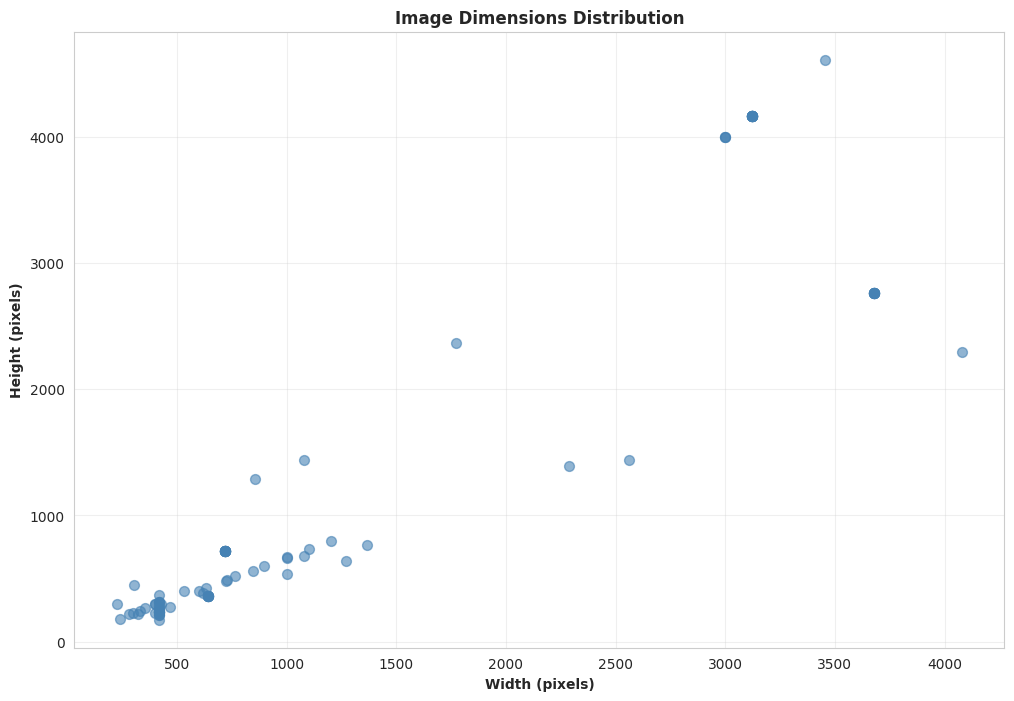

In [30]:
# Create comprehensive visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Image dimensions
ax.scatter(df_train_props['width'], df_train_props['height'], 
                   alpha=0.6, color='steelblue', s=50)
ax.set_xlabel('Width (pixels)', fontweight='bold')
ax.set_ylabel('Height (pixels)', fontweight='bold')
ax.set_title('Image Dimensions Distribution', fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3)

> Dari persebaran dimensi gambar di atas, terlihat sebagian besar citra memiliki resolusi 1500 x 1000 piksel dan terpusat di sisi kiri bawah. Kemungkinan gambar dalam dataset ini merupakan versi resolusi asli dari *dashcam*. Namun demikian, terdapat juga titik resolusi yang tinggi ekstrem (mencapai 4000+ piksel). Resolusi yang tinggi ini jika tidak ditangani dengan downscaling/resize, maka akan memicu proses komputasi yang lebih. Persebaran dimensi juga tidak membentuk garis linear sempurna Titik yang cenderung melebar ke sumbu X merepresentasikan citra landscape, sementara titik yang meninggi ke sumbu Y merepresentasikan citra portrait. Inkonsistensi geometris seperti ini perlu ditangani dengan metode Multi-Scale Resizing atau Tiling saat preprocessing agar gambar tidak terdistorsi serta mempertahankan resolusi original.

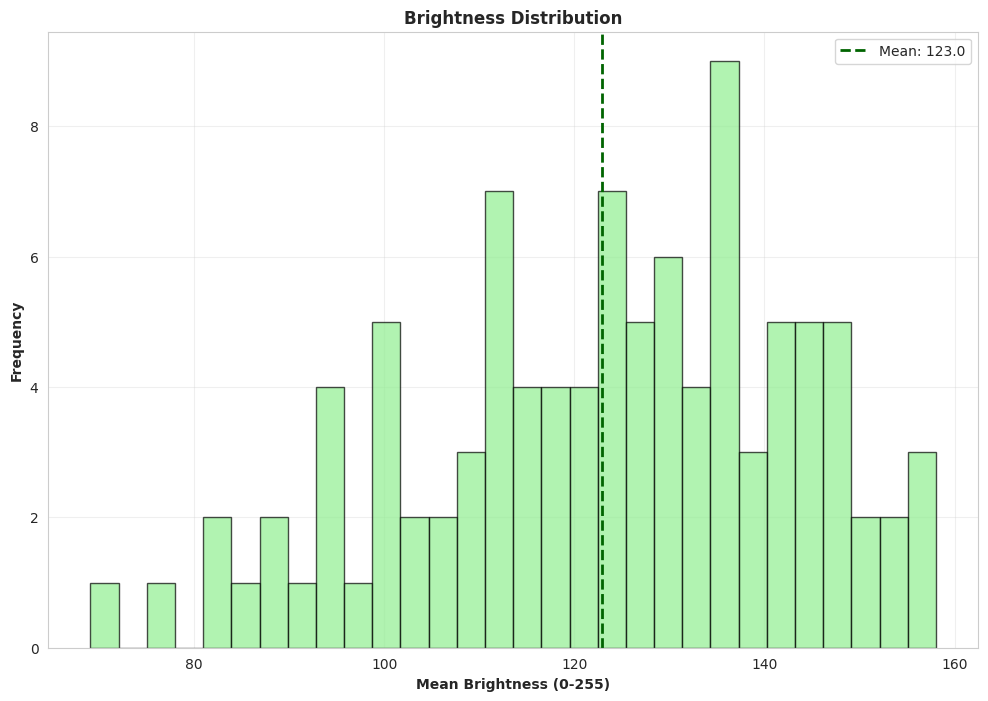

In [31]:
# Brightness distribution
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(df_train_props['mean_brightness'], bins=30, color='lightgreen', 
                edgecolor='black', alpha=0.7)
ax.axvline(df_train_props['mean_brightness'].mean(), color='darkgreen', 
                   linestyle='--', linewidth=2,
                   label=f"Mean: {df_train_props['mean_brightness'].mean():.1f}")
ax.set_xlabel('Mean Brightness (0-255)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Brightness Distribution', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

> Distribusi level kecerahan pada citra tersegmen di tengah dengan rata-rata 123, yang menandakan eksposur pada citra hampir sempurna. Mayoritas citra diambil dengan pencahayaan yang cukup, namun terdapat variasi kecerahan (pada interval 70 hingga 160) yang kerap terjadi karena waktu pengambilan citra yang berbeda. Kecerahan citra sudah cukup ideal dengan tidak adanya frekuensi pada area ekstrem (dekat 0 atau 255), ini menandakan minimnya masalah underexposure atau overexposure. Meskipun distribusi pencahayaan global sudah ideal, deteksi lubang jalan sangat bergantung pada tekstur bayangan lokal di dalam lubang itu sendiri. Langkah augmentasi yang diterapkan adalah CLAHE, untuk membuat transisi antara aspal dengan lubang jalan menjadi lebih jelas namun tidak mengubah brightness secara ekstrem. Ini akan menonjolkan tekstur permukaan jalan agar lubang lebih mudah diekstrak model.

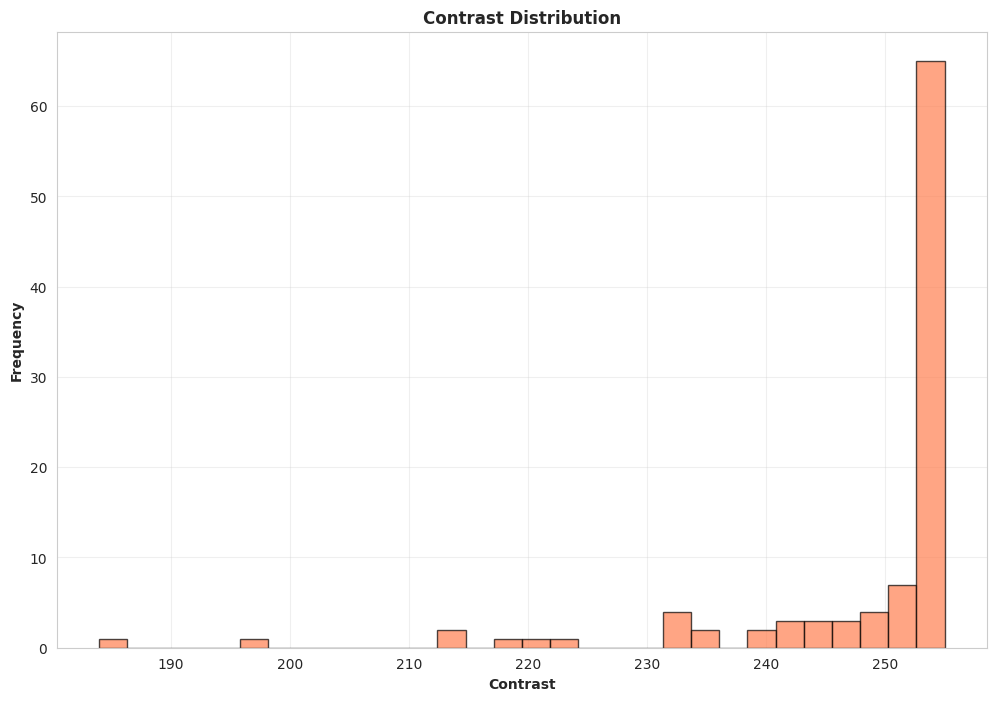

In [32]:
# Contrast Distribution
fig, ax  = plt.subplots(figsize=(12, 8))

ax.hist(df_train_props['contrast'], bins=30, color='coral', 
                edgecolor='black', alpha=0.7)
ax.set_xlabel('Contrast', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Contrast Distribution', fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3)

> Pola persebaran kontras pada dataset sangat menunjukkan pola distribusi condong negatif, dengan lebih dari 60 citra bernilai kontras mendekati maksimum (255). Nilai kontras di range 250-255 ini membuktikan bahwa citra sangat mudah dibedakan antara gelap dan terang. Ini sesuai dengan karakteristik alami dari citra jalan raya aspal, dimana terdapat perbedaan intensitas yang tajam antara permukaan aspal (gelap/abu-abu), marka jalan (putih), dan pantulan cahaya matahari. Absennya data pada rentang kontras rendah menandakan tidak terdapat permasalahan berarti dari kontras citra aspal. Kontras yang tinggi akan mempermudah convolutional filters dalam mendeteksi *boundary* antara lubang jalan dan permukaan jalan tanpa proses berat mempertajam gambar. Namun, untuk membuat kedalaman plot lubang menjadi lebih jelas, bisa diaplikasikan metode Gamma Carrection Augmentation agar model andal di segala kondisi cuaca, sekalipun ekstrem.

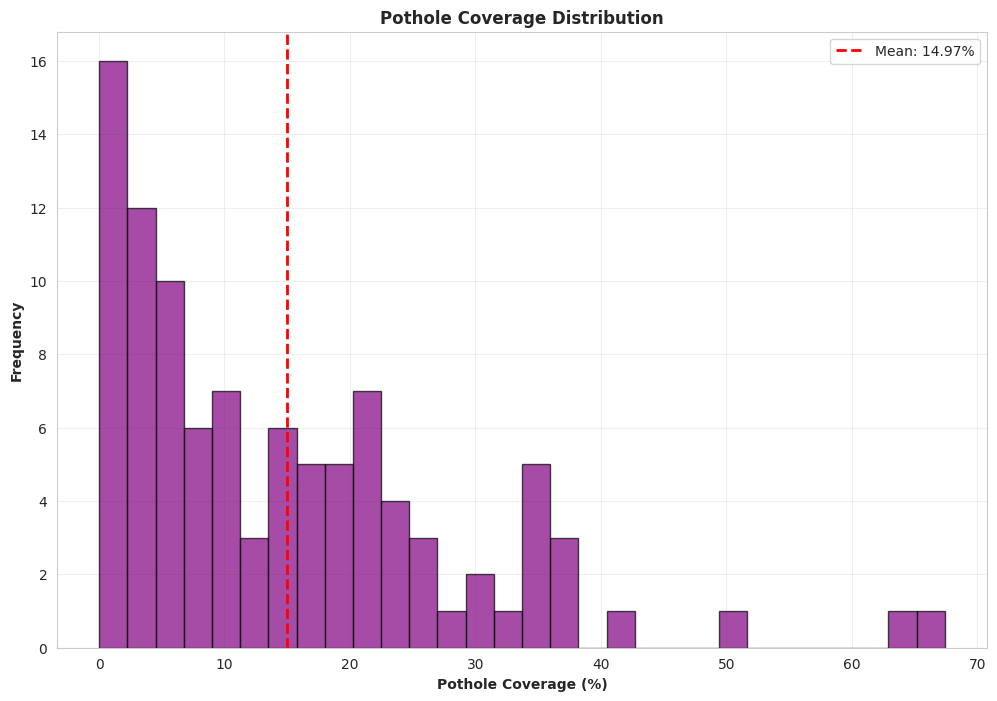

In [33]:
# Pothole coverage distribution
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(df_masks['pothole_ratio']*100, bins=30, color='purple', 
                edgecolor='black', alpha=0.7)
ax.axvline(df_masks['pothole_ratio'].mean()*100, color='red', 
                   linestyle='--', linewidth=2,
                   label=f"Mean: {df_masks['pothole_ratio'].mean()*100:.2f}%")
ax.set_xlabel('Pothole Coverage (%)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Pothole Coverage Distribution', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

> Visualisasi cakupan lubang jalan menggambarkan pola distribusi condong ke kanan, yang mengindikasikan mayoritas sampel lubang jalan memiliki kerusakan ringan hingga menengah. Meskipun didominasi kerusakan jalan ringan, terdapat fenomena long-tail - sejumlah kecil citra punya coverage kerusakan ekstrem di atas 50%. Keberadaan sampel dengan cakupan >60% ini kemungkinan besar merupakan citra close-up atau kerusakan struktural masif. Model yang dipilih harus beradaptasi dengan variasi skala ini agar tidak menganggap lubang besar sebagai aspal jalan. Sedangkan untuk nilai rata-rata cakupan tercatat cukup tinggi yaitu 14.97%. Rata-rata segini tergolong besar dan mengkonfirmasi bahwa sampel lubang jalan ini berisi objek target yang cukup mencolok, yang secara teoritis akan mempermudah model dalam mempelajari fitur tekstur aspal yang rusak.

model lebih bagus prediksi mana? Yang pothole nya kecil atau yang pothole nya besar?

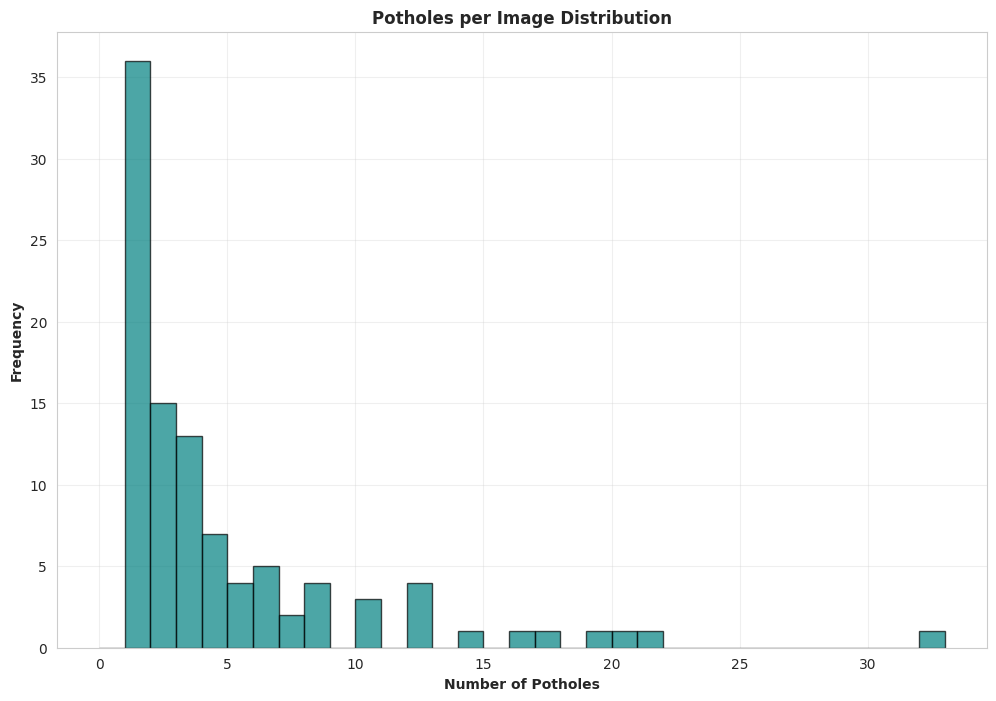

In [34]:
# Number of potholes per image
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(df_masks['num_potholes'], 
                bins=range(0, int(df_masks['num_potholes'].max())+2), 
                color='teal', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Potholes', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Potholes per Image Distribution', fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3)

> Terlihat bahwa lubang di kebanyakan sampel jalan sebanyak satu yang diikuti penurunan frekuensi yang tajam pada nilai 2 hingga 5. Ini menandakan bahwa sebagian besar sampel merepresentasikan kerusakan jalan yang terisolasi, yang relatif lebih mudah disegmentasi oleh model. Di sisi lain, terdapat sejumlah kecil citra outlier dengan jumlah lubang cukup banyak (> 20), ini mengindikasikan adanya long-tail distribution. Keberadaan sampel ekstrem ini merepresentasikan kondisi jalan yang rusak parah sehingga membuat kemampuan model dalam memisahkan fitur-fitur yang saling berdekatan lebih berat. Tantangan utama pada citra dengan jumlah pothole tinggi (>10) adalah risiko 'Merging Artifacts'. Pada arsitektur segmentasi semantik, lubang-lubang kecil yang berdekatan cenderung diprediksi sebagai satu area kerusakan besar yang menyatu. Dengan demikian, Random Saturation jitter bisa diterapkan untuk mengabaikan intensitas warna.

Text(0.5, 1.0, 'Average Class Distribution')

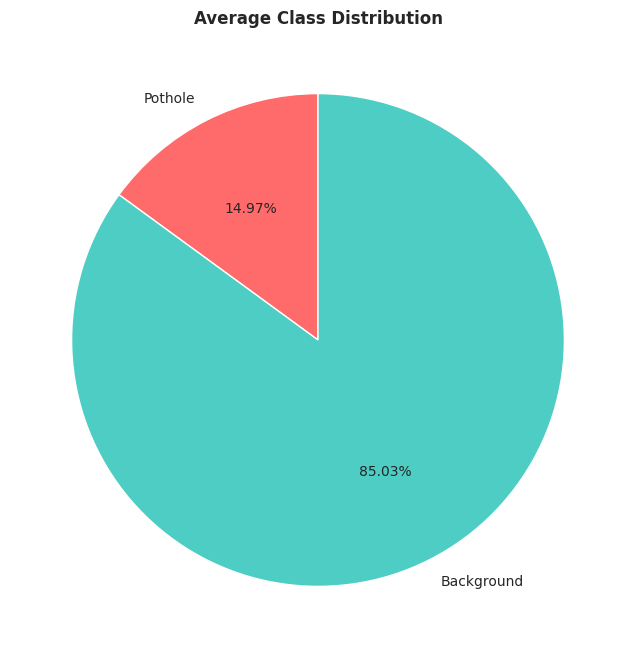

In [35]:
# Class balance pie chart
fig, ax = plt.subplots(figsize=(12, 8))

class_data = [avg_pothole_ratio * 100, avg_background_ratio * 100]
colors_pie = ['#ff6b6b', '#4ecdc4']
ax.pie(class_data, labels=['Pothole', 'Background'], 
               autopct='%1.2f%%', colors=colors_pie, startangle=90)
ax.set_title('Average Class Distribution', fontweight='bold', fontsize=12)

> Dari grafik pie perbandingan antara lubang jalan dengan latar belakang, objek aspal mendominasi dengan mencakup 85.03% dari total piksel dalam dataset. Sedangkan untuk kelas Target (Pothole) hanya merepresentasikan 14.97%. Ketimpangan ini mengonfirmasi bahwa model akan menghadapi kondisi data imbalance, di mana model memiliki kecenderungan alami untuk memprediksi citra sebagai latar belakang (aspal). Dengan cakupan lubang jalan hampir 15%, kerusakan jalan dalam sampel ini relatif jelas dibedakan, bukan sekadar goresan kecil yang sulit dilihat.

# 6. Images & Masks Visualization

Tampilan Visualisasi 3 data...


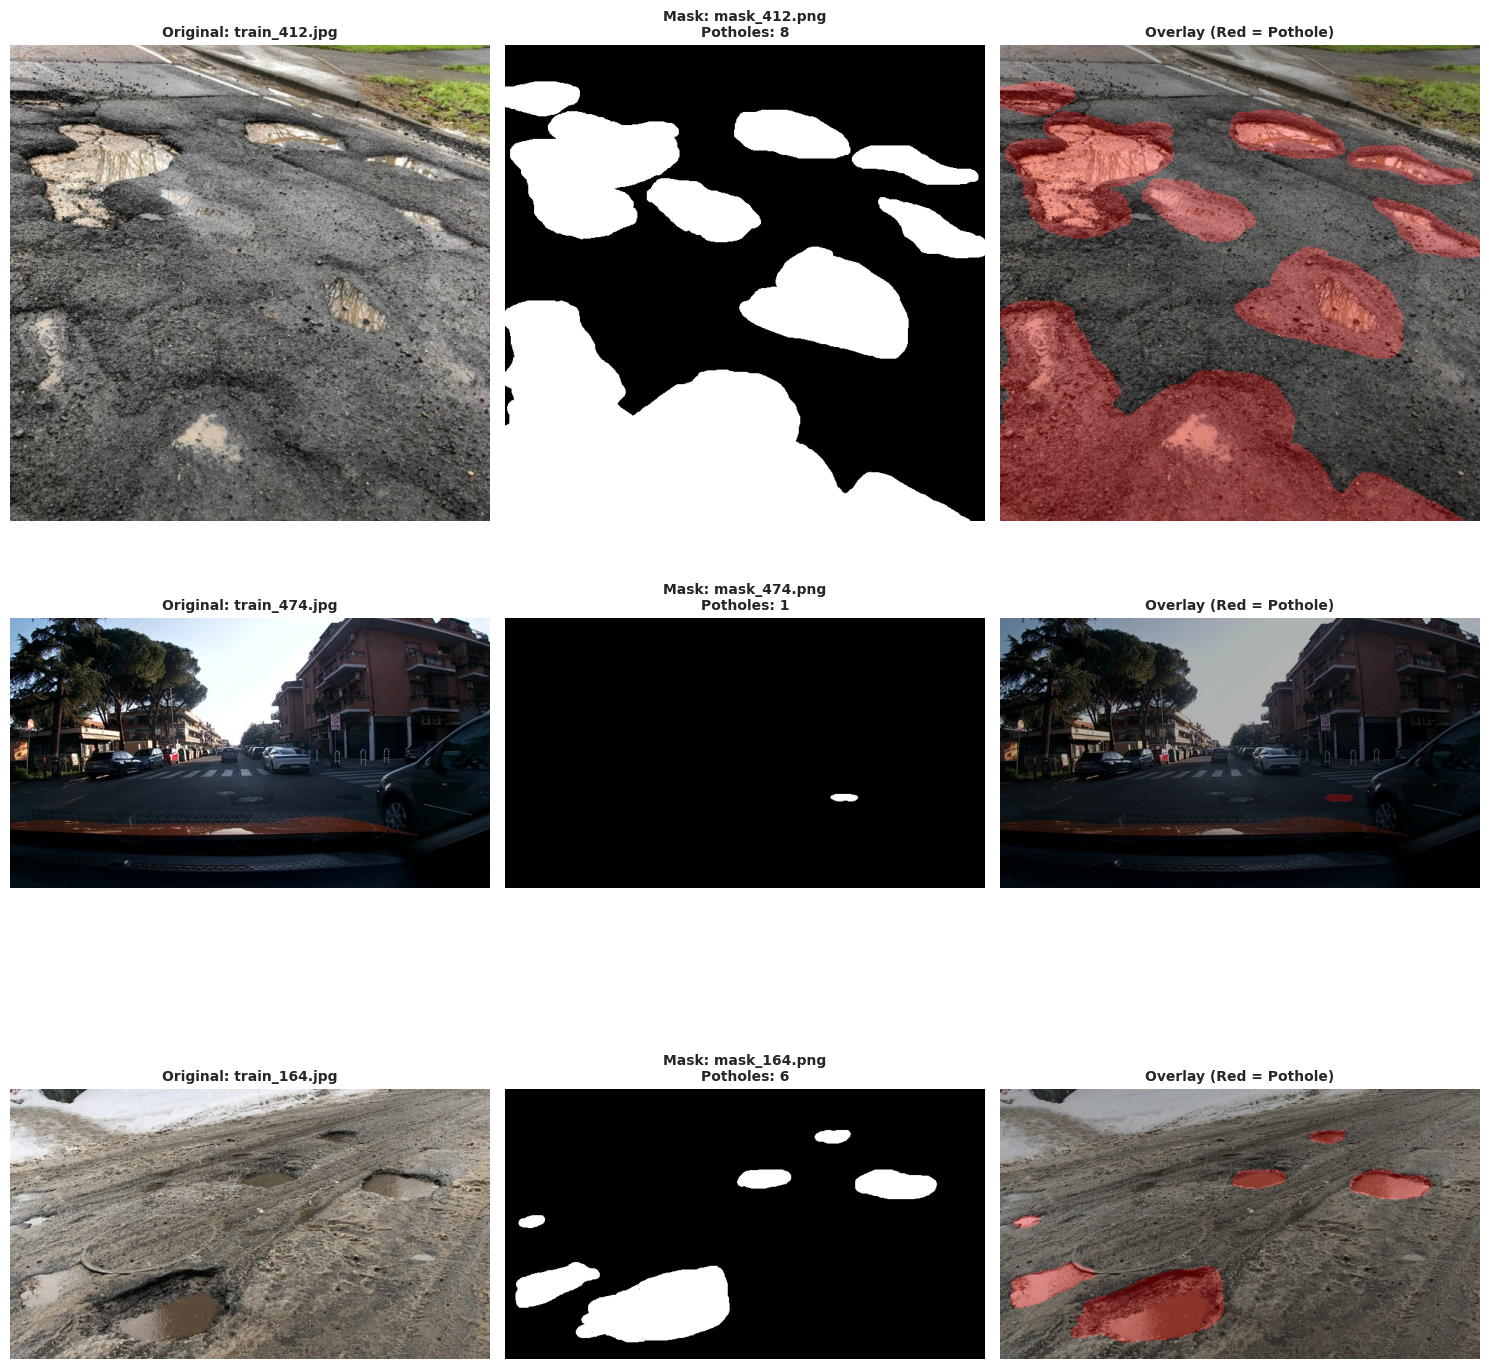

In [36]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(image_dir, mask_dir, image_list, mask_list, num_samples=6):
    """Visualize sample images with their masks and overlays"""
    
    # Filter data agar tidak error jika jumlah file sedikit
    num_samples = min(num_samples, len(mask_list))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Jika hanya 1 sample, axes tidak berupa array 2D, jadi kita buat array
    if num_samples == 1:
        axes = np.array([axes])

    # Ambil sample (bisa acak atau urut)
    # Kita ambil acak saja biar variatif
    indices = np.random.choice(len(mask_list), num_samples, replace=False)
    selected_files = [mask_list[i] for i in indices]
    
    print(f"Tampilan Visualisasi {num_samples} data...")
    
    for idx, mask_file in enumerate(selected_files):
        # --- PERBAIKAN LOGIKA DI SINI ---
        # Mengubah 'mask_XXX.png' menjadi 'train_XXX.jpg'
        img_file = mask_file.replace('mask', 'train').replace('.png', '.jpg')
        
        # Cek path lengkap
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Baca Image
        img = cv2.imread(img_path)
        
        # Error Handling: Jika gambar tidak ketemu, print errornya
        if img is None:
            print(f"⚠️ Gagal membaca gambar: {img_file} di {image_dir}")
            # Lewati iterasi ini tapi biarkan plot kosong
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Baca Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            print(f"⚠️ Gagal membaca mask: {mask_file}")
            continue
        
        # Create overlay
        overlay = img.copy()
        mask_colored = np.zeros_like(img)
        mask_colored[mask > 127] = [255, 0, 0]  # Merah untuk pothole
        overlay = cv2.addWeighted(img, 0.7, mask_colored, 0.3, 0)
        
        # Calculate stats
        pothole_ratio = (mask > 127).sum() / mask.size * 100
        num_labels = cv2.connectedComponents(mask)[0] - 1
        
        # Plot Image Asli
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Original: {img_file}', fontweight='bold', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Plot Mask
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title(f'Mask: {mask_file}\nPotholes: {num_labels}', fontweight='bold', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Plot Overlay
        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title('Overlay (Red = Pothole)', fontweight='bold', fontsize=10)
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- JALANKAN FUNGSI ---
# Pastikan path ini sudah benar sesuai perbaikan sebelumnya
train_images_path = '/kaggle/input/data-science-ara-7-0/dataset/dataset/train/images'
train_mask_path = '/kaggle/input/data-science-ara-7-0/dataset/dataset/train/mask' 

# Ambil list file mask terbaru
train_masks = os.listdir(train_mask_path)
train_images = os.listdir(train_images_path)

visualize_samples(train_images_path, train_mask_path, train_images, train_masks, num_samples=3)

# 7. Challenge Identification

In [37]:
print("="*70)
print(" DATASET CHALLENGES IDENTIFICATION ".center(70, "="))
print("="*70)

challenges = []

# Challenge 1: Small potholes
small_pothole_ratio = (df_masks['pothole_ratio'] < 0.01).sum() / len(df_masks) * 100
if small_pothole_ratio > 20:
    challenges.append({
        'type': 'Small Potholes',
        'severity': 'HIGH',
        'description': f'{small_pothole_ratio:.1f}% images have very small potholes (<1% coverage)',
        'recommendation': 'Use attention mechanisms, multi-scale features, higher resolution'
    })

# Challenge 2: Class imbalance
if avg_pothole_ratio < 0.1:
    challenges.append({
        'type': 'Severe Class Imbalance',
        'severity': 'CRITICAL',
        'description': f'Only {avg_pothole_ratio*100:.2f}% pothole vs {(1-avg_pothole_ratio)*100:.2f}% background',
        'recommendation': 'MUST use Dice Loss, Focal Loss, or weighted BCE'
    })

# Challenge 3: Variable lighting
brightness_cv = df_train_props['std_brightness'].mean() / df_train_props['mean_brightness'].mean()
if brightness_cv > 0.3:
    challenges.append({
        'type': 'Variable Lighting',
        'severity': 'MEDIUM',
        'description': f'High brightness variation (CV: {brightness_cv:.2f})',
        'recommendation': 'Apply CLAHE, brightness/contrast augmentation'
    })

# Challenge 4: Multiple potholes
multi_pothole_ratio = (df_masks['num_potholes'] > 1).sum() / len(df_masks) * 100
if multi_pothole_ratio > 30:
    challenges.append({
        'type': 'Multiple Potholes per Image',
        'severity': 'MEDIUM',
        'description': f'{multi_pothole_ratio:.1f}% images contain multiple potholes',
        'recommendation': 'Model must handle multiple instances, avoid merging separate potholes'
    })

# Challenge 5: Inconsistent dimensions
if len(unique_dims) > 1:
    challenges.append({
        'type': 'Inconsistent Image Dimensions',
        'severity': 'LOW',
        'description': f'{len(unique_dims)} different image sizes',
        'recommendation': 'Resize to consistent dimensions (512x512 or 768x768)'
    })

print(f"\n🔍 Identified {len(challenges)} key challenges:\n")
for i, challenge in enumerate(challenges, 1):
    print(f"{i}. {challenge['type']} [{challenge['severity']}]")
    print(f"   Issue: {challenge['description']}")
    print(f"   → Solution: {challenge['recommendation']}\n")

================= DATASET CHALLENGES IDENTIFICATION ==================

🔍 Identified 3 key challenges:

1. Variable Lighting [MEDIUM]
   Issue: High brightness variation (CV: 0.38)
   → Solution: Apply CLAHE, brightness/contrast augmentation

2. Multiple Potholes per Image [MEDIUM]
   Issue: 64.0% images contain multiple potholes
   → Solution: Model must handle multiple instances, avoid merging separate potholes

3. Inconsistent Image Dimensions [LOW]
   Issue: 54 different image sizes
   → Solution: Resize to consistent dimensions (512x512 or 768x768)



In [38]:
# Cek Challenge 4: Multiple potholes
multi_pothole_ratio = (df_masks['num_potholes'] > 1).sum() / len(df_masks) * 100
print(f"Rasio Multiple Potholes = {multi_pothole_ratio:.2f}% (Threshold > 30)") # Tambah ini
if multi_pothole_ratio > 30:
    challenges.append({ ... })

# Cek Challenge 5: Inconsistent dimensions
print(f"Jumlah Variasi Ukuran = {len(unique_dims)} (Threshold > 1)") # Tambah ini
if len(unique_dims) > 1:
    challenges.append({ ... })

Rasio Multiple Potholes = 64.00% (Threshold > 30)
Jumlah Variasi Ukuran = 54 (Threshold > 1)


# 8. Tambahan hasil dan insight Exploratory Data Analysis dari Dataset yang diberikan

## 1. Kecerahan pada model perlu untuk ditingkatkan karena dari hasil ketiga visualisasi, data masih mengalami kesusahan dalam distribusi kecerahan.
## 2. Augmentasi model dengan menajamkan filter dan menambah tepian agar model lebih jelas membedakan mana yang aspal (latar belakang), mana yang lubang jalan (yang dilatih).
## 3. Kecendrungan citra untuk bergerak cukup tinggi, yang menanadakan kondisi aspal jalan yang difoto memiliki visual rumit dan banyak noice. Untuk menghaluskan noice aspal ini, filter median atau total variaito denoising bisa diterapkan.
## 4. Untuk membuat kedalaman lubang aspal menjadi lebih clear, memakai metode Local Contrast Enhancement atau Gamma Correction, meskipun tidak terdapat masalah dalam kontras yang berarti.
## 5. Pola persebaran gambar tidak konsisten, resolusi citra diambil berbeda-beda, sehingga membutuhkan penerapan multi-scale feature extraction.
## 6. Cahaya terang yang membuat citra buram dapat diatasi dengan sedikit memvariasikan bagian properti warna gambar (color jittering) dan mengacak saturasi.
## 7. Untuk membuat bayangan yang menentukan lubang lebih tempak, perlu meratakan distribusi nilai intensitas piksel dengan histogram equilization.
## 8.  Kompleksitas geometri permukaan jalan yang kasar membutuhkan *random cropping* untuk melatih model agar tidak salah mengartikan tekstur aspal alami sebagai lubang. Mengingat sebaran intensitas cahaya yang signifikan dari rentang 60 hingga 190, diperlukan *Global Value Normalization* untuk menstandarisasi variasi pencahayaan pada seluruh dataset. Langkah normalisasi ini memastikan model dapat mempelajari fitur struktural kerusakan jalan tanpa terganggu perbedaan *brightness* akibat cuaca atau bayangan.
## 9. Disebabkan citra lubang jalan masih terdapat outlier, Random Saturation Jitter perlu diterapkan untuk mengabaikan intensitas warna.
## 10. Ada 350 gambar yang berlatar waktu siang hari dan ada 120 gambar yang berlatar waktu senja/fajar. Maka dari itu, pakai augmentasi malam (*low-light*) sintetis.
## 11. Kondisi pencahayaan dataset cenderung normal dan bisa diterapkan Gamma Correct Augmentation untuk mensimulasikan kondisi pencahayaan ekstrem agar model tetap handal di segala cuaca.
## 12. Antara lubang jalan dengan bayangan sama-sama berwarna hitam dan rawam terjadi kesalahpahaman. Bisa ditangani dengan Shadow Augmentation untuk melatih model membedakan perubahan warna akibat bayangan dengan kedalaman lubang.
## 13. Terdapat potensi hilangnya informasi tekstur akibat pantulan cahaya pada aspal. Dapat diatasi dengan Specular High atau Lens Flare Augmentation agar model mampu memahami geometri jalan yang mendasar meski dalam kondisi silau.
## 14. Tekstur sampel permukaan citra jalan cukup kompleks, model perlu dilatih agar tidak bias dan bisa membedakan kondisi jalan - mana yang tekstur kasar alami dan mana yang memang pothole. Bisa memakai Class-Balanced Sampling.
## 15. Resolusi pada citra sangat beragam, apabila citra beresolusi tinggi dipaksa jadi kecil, maka akan mempengaruhi lubang kecil. Solusi yang disarankan adalah memakai metode Tiling atau Multi Scale Resizing, dimana gamnbar besar akan dipotong menjadi kotak-kotak kecil tanpa mengubah ukurannya. Ini akan menjaga lubang kecil tersebut tetap tajam.
## 16. Kinerja model tidak dinilai menggunakan satu metrik global semata, melainkan dipecah berdasarkan kondisi data (Stratified IoU) untuk mengidentifikasi failure modes yang meliputi kinerja berdasarkan ukuran objek, kinerja berdasarkan kondisi pencahayaan dan kinerja berdasarkan rasio aspek citra asli. Proses ini dinamakan Stratified Error Analysis.
## 17. Bayangan objek pada pohon atau bangunan kerap bernilai piksel gelap, mirip lubang jalan dan memicu False Positive. Langkah yang bisa dilakukan untuk mengatasi kendala ini adalah dengan Mask-to-Image Correlation Filter. Setiap area prediksi dievaluasi berdasarkan standar deviasi intensitas pikselnya. Area dengan std dev rendah (homogen/halus) diklasifikasikan sebagai bayangan, sedangkan area dengan std dev tinggi (kasar/beragam) diklasifikasikan sebagai lubang Jalan.